# Connected Polynomial Guidance

Pure python implementation of the connected polynomial guidance approach developed by Guru Singh. Reproduces both examples from the reference. 

Reference: IOM 3433-20-001

In [63]:
import numpy as np
import matplotlib.pyplot as plt 

## Definition of Inputs and Vehicle Parameters

In [100]:
target_alt = 500

# Vehicle Parameters 
Tmax = 31198.7 # N 
tau_max = 0.8
tau_min = 0.2 
inefficiency = 0.98481
Isp = 220
g0 = 9.807

# Initial Conditions 
m0 = 2650
x0 = 0
y0 = 0 
z0 = 2500

V = 100
fpa = np.radians(-65)
vx = V*np.cos(fpa)
vy = 0
vz = V*np.sin(fpa)

# These are problem/vehicle specific, fixed values 
z1 = 1050
dz1 = 0 

p0 = [x0, y0, z0]
v0 = [vx, vy, vz]
x0 = np.array(p0+v0)



In [114]:
def coeff(x0, dx0, x1, dx1, xf, Ta, Tb):
    cxa5 = -7/6 * (3*x0-3*x1+dx0*Ta+2*dx1*Ta)
    cxa = np.array([x0, dx0*Ta, -cxa5-6*x0+6*x1-3*dx0*Ta-3*dx1*Ta, 3*cxa5+8*x0-8*x1+3*dx0*Ta+5*dx1*Ta, -3*cxa5-3*x0+3*x1-dx0*Ta-2*dx1*Ta, cxa5])[::-1]
    
    cxb6 = 1.5*dx1*Tb
    cxb = np.array([x1, dx1*Tb, 0, -1*cxb6 - 10*x1 - 6*Tb*dx1 + 10*xf, 3*cxb6 + 15*x1 + 8*Tb*dx1 - 15*xf, -3*(cxb6 + 2*x1 + Tb*dx1 - 2*xf), cxb6])[::-1]
    return cxa, cxb

def solve(initial_state, target_state, final_vertical_accel, interior_point, debug=False):
    p0 = initial_state[:3]
    v0 = initial_state[3:]
    
    pf = target_state[:3]
    vf = target_state[3:]
    
    z1, dz1 = interior_point 
    
    x0,y0,z0, dx0,dy0,dz0 = initial_state # for easy access to individual states 
    xf,yf,zf, dxf,dyf,dzf = target_state
    
    # Compute r boundary conditions
    r = pf-p0
    r[2] = 0 
    rhat = r/np.linalg.norm(r)
    alpha,beta,unused = rhat
    dr0 = np.dot(rhat, v0)
    rf = np.dot(rhat, pf-p0)
    
    # Segment times 
    Ta = -2*(z0-z1)/(dz0+dz1)
    Tb = -2*(z1-zf)/(dz1+dzf)
    if debug:
        print("Ta = {:.2f}".format(Ta))
        print("Tb = {:.2f}".format(Tb))    
    
    # Interior Point r coordinates 
    num = 56*(-16*Ta**2 - 15*Ta*Tb+4*Tb**2)*dr0 + 120*(16*Ta+15*Tb)*rf
    den = 1024*Ta**2 + 1920*Ta*Tb + 1349*Tb**2
    dr1 = num/den
    r1 = Ta*(7*dr0 + 8*dr1)/15
    if debug:
        print("r1 = {:.2f}".format(r1))
        print("dr1 = {:.2f}".format(dr1))
    
    x1 = x0 + alpha*r1
    y1 = y0 + beta*r1
    
    dx1 = alpha*dr1
    dy1 = beta*dr1 
    
    # Get the coefficients...very tedious 
    cxa,cxb = coeff(x0, dx0, x1, dx1, xf, Ta, Tb)
    cya,cyb = coeff(y0, dy0, y1, dy1, yf, Ta, Tb)
    cza = np.array([z0, dz0*Ta, -dz0*Ta - z0 + z1])[::-1]
    czb = np.array([z1, dz1*Tb, -dz1*Tb - z1 + zf])[::-1] # reversing them makes them usable with polyval 
    
    # Times at which to evaluate the trajectory 
    ta = np.linspace(0, Ta)
    tb = np.linspace(0, Tb)
    
       
    def get_reference_state(time):
        # lets just assume time is a vector rather than a scalar 
        
        a = time <= Ta
        b = np.invert(a)
        ta = time[a]
        tb = time[b]-ta[-1]
        
        xa = np.polyval(cxa, ta/Ta)
        xb = np.polyval(cxb, tb/Tb)
        x = np.hstack([xa,xb])
        
        ya = np.polyval(cya, ta/Ta)
        yb = np.polyval(cyb, tb/Tb)
        y = np.hstack([ya,yb])

        za = np.polyval(cza, ta/Ta)
        zb = np.polyval(czb, tb/Tb)
        z = np.hstack([za,zb])
        
        dxa = np.polyval(np.polyder(cxa), ta/Ta)/Ta
        dxb = np.polyval(np.polyder(cxb), tb/Tb)/Tb
        dx = np.hstack([dxa,dxb])
        
        dya = np.polyval(np.polyder(cya), ta/Ta)/Ta
        dyb = np.polyval(np.polyder(cyb), tb/Tb)/Tb
        dy = np.hstack([dya,dyb])        
        
        dza = np.polyval(np.polyder(cza), ta/Ta)/Ta
        dzb = np.polyval(np.polyder(czb), tb/Tb)/Tb
        dz = np.hstack([dza,dzb])
        
        return np.array([x, y, z, dx, dy, dz]).T
    
    def get_reference_accel(time):
        a = time <= Ta
        b = np.invert(a)
        ta = time[a]
        tb = time[b]-Ta
        
        accel = []
        for ca,cb in [(cxa,cxb), (cya,cyb), (cza,czb)]:
            ddxa = np.polyval(np.polyder(ca, 2), ta/Ta)/Ta**2
            ddxb = np.polyval(np.polyder(cb, 2), tb/Tb)/Tb**2
            accel.append(np.hstack([ddxa,ddxb]))       
        accel[2] += 3.71 # we want to return only the thrust accelerations, so we remove the gravitational effects 
        return np.array(accel).T
    
    # This should have absolutely everything we need 
    solution = {'coeff': {'a':[cxa, cya, cza], 'b': [cxb, cyb, czb]},
                'times': {'Ta': Ta, 'Tb': Tb,"Tf": Ta+Tb},
                'reference': get_reference_state,               
               } 
    
    # Just for testing purposes 
    if debug:
        t = np.linspace(0, Ta+Tb, 500)
        x,y,z,dx,dy,dz = get_reference_state(t).T
        
        acc = get_reference_accel(t)
        accel_norm = np.sqrt(np.sum(acc**2, axis=1))
        
        m = [m0]
        for accel in accel_norm[:-1]:
            m.append(m[-1] - accel*m[-1]*t[1]/Isp/g0/inefficiency)
        m = np.array(m)
        mprop = m0-m
        
        print("Prop used: {:.3f} kg".format(mprop[-1]))
        T = m*accel_norm/inefficiency
        
        plt.figure()
        plt.title("Positions")
        plt.plot(x, z, label="Along track")
        plt.plot(y, z, label="Cross track")
        plt.ylabel('Altitude (m)')
        plt.xlabel("Horizontal distance (m)")
        plt.legend()
        
        plt.figure()
        plt.plot(t, dx, label='vx')
        plt.plot(t, dy, label='vy')
        plt.plot(t, dz, label='vz')
        plt.plot(t, np.sqrt(dx**2 + dy**2 + dz**2), 'k--', label='||V||')
        plt.xlabel('Time (s)')
        
        plt.legend()
        
        plt.figure()
        plt.plot(t, mprop)
        plt.ylabel("Prop Used (kg)")   
        plt.xlabel('Time (s)')
        
        plt.figure()
        plt.plot(t, T/Tmax)
        plt.ylabel("Throttle %")
        plt.xlabel('Time (s)')
        
        plt.show()
    return solution 

Ta = 32.00
Tb = 36.67
r1 = 1295.57
dr1 = 112.90
Prop used: 482.869 kg


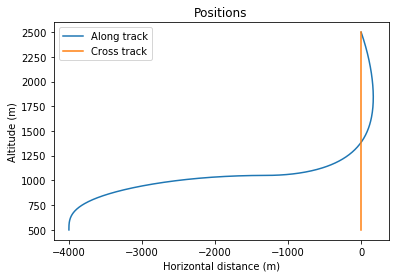

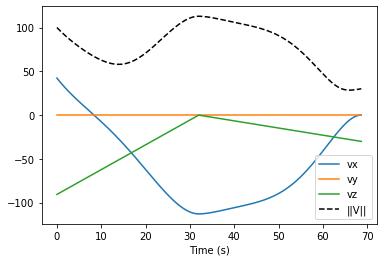

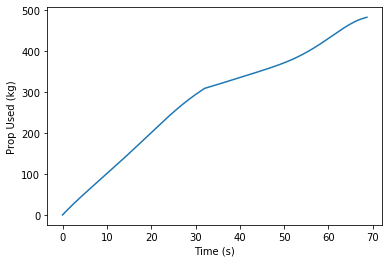

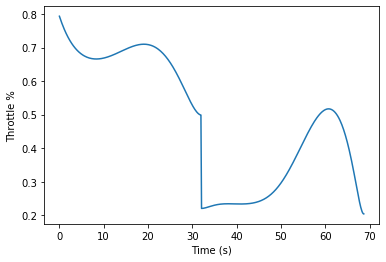



Ta = 32.00
Tb = 36.67
r1 = 1700.78
dr1 = 99.66
Prop used: 455.604 kg


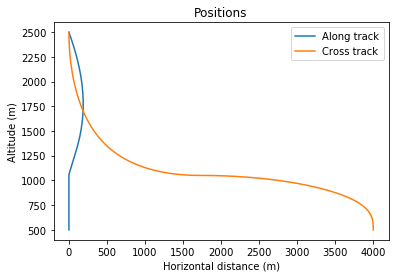

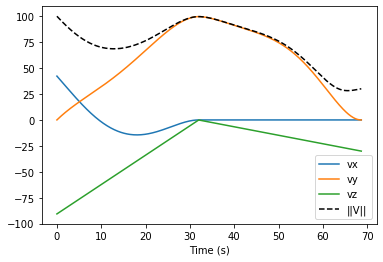

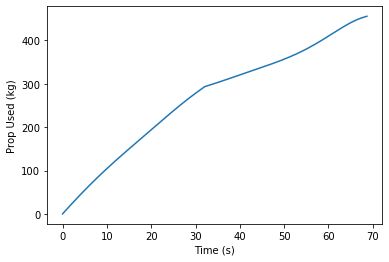

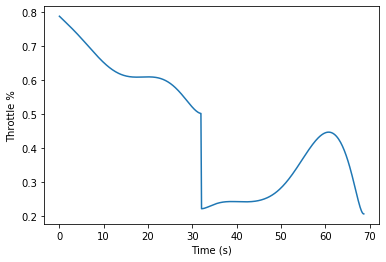

In [115]:
# Target conditions 
pf1 = [-4000, 0, target_alt] # case 1 in the memo
pf2 = [0, 4000, target_alt]  # case 2
vf = [0, 0, -30]

for pf in [pf1, pf2]:
    xf = np.array(pf+vf)
    sol = solve(x0, xf, 0, [z1, dz1], debug=True)
    print("\n")